In [ ]:
%load_ext autoreload
%autoreload 2
%pdb 0

In [2]:
import pandas as pd
import numpy as np
import csrar
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm

In [3]:
data = pd.read_csv('../data/page-blocks0.csv')

In [ ]:
# For rootkit_imap...
for cat_col in ['Atr-1', 'Atr-2', 'Atr-3']:
    data[cat_col] = pd.Categorical(data[cat_col])
    data[cat_col] = data[cat_col].cat.codes

In [4]:
# For page-block0.csv, convert 'positive'/'negative' to 0 and 1
data['Class'] = pd.Categorical(data['Class'])
data['Class'] = data['Class'].cat.codes

In [5]:
data.dtypes

Height        int64
Length        int64
Area        float64
Eccen       float64
P_black     float64
P_and       float64
Mean_tr     float64
Blackpix      int64
Blackand      int64
Wb_trans      int64
Class          int8
dtype: object

In [6]:
uniques = np.unique(data['Class'], return_counts=True)
perc = list(map(lambda c: c/len(data), uniques[1]))
perc

[0.89784356725146197, 0.10215643274853801]

In [2]:
import arff
file = open('../data/test5.arff', 'r')
dataset = arff.load(file)
data = pd.DataFrame(dataset['data'])

In [3]:
data[150] = data[150].astype(np.float32)

In [4]:
# Artificially imbalance dataset
class0 = data.loc[data[150] == 0]
class1 = data.loc[data[150] == 1]
imb_data = pd.concat([class1.sample(frac=0.1), class0]).reset_index(drop=True)
# For perfectly balanced dataset, this will result in a 97.56:2.44 ratio

#### About test2.arff:
useful=Vector(0, 1)  
dependent=Vector(5, 6, 7, 8, 9)  
duplicated=Vector((0,12), (4,10), (6,11))  
nominal=List()  
clusters=[(0, 1, 2), (3, 4)]  
distribution=List(24860, 25140)  
seed=0
#### About test3.arff
useful=Vector(0, 1)  
dependent=Vector(5, 6, 7, 8, 9)  
duplicated=Vector((0,12), (4,10), (6,11))  
nominal=List()  
clusters=[(0, 1, 2), (3, 4)]  
distribution=List(249786, 250214)  
#### About test4.arff
useful=Vector(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29)  
dependent=Vector(100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149)  
duplicated=Vector((7,168), (10,157), (24,159), (28,162), (30,166), (50,169), (61,154), (82,158), (99,167), (104,156), (107,151), (113,164), (117,155), (117,165), (124,150), (135,160), (139,152), (145,161), (146,153), (147,163))  
nominal=List()  
clusters=[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), (10, 11, 12, 13, 14), (15, 16, 17)]  
distribution=List(250085, 249915)  
#### About test5.arff
useful=Vector(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)  
dependent=Vector(80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109)  
duplicated=Vector((4,118), (8,114), (8,146), (9,137), (9,144), (10,131), (17,123), (22,116), (24,120), (24,142), (25,125), (35,127), (42,119), (43,122), (45,111), (48,134), (50,132), (52,110), (54,138), (57,112), (57,115), (57,149), (62,141), (64,136), (70,117), (70,148), (73,126), (76,133), (77,140), (78,143), (83,113), (84,139), (91,145), (92,121), (93,128), (93,135), (95,124), (103,129), (104,130), (105,147))  
nominal=List()  
clusters=[(0, 1, 2), (3, 4), (5, 6, 7, 8, 9, 10, 11, 12, 13, 14)]  
distribution=List(99718, 100282)  


### Train/Test Split

In [7]:
target = 'Class'
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

## RaR

In [ ]:
scores = 0
for i in range(5):
    rar_data = pd.concat([X_train, y_train], axis=1)
    # RaR uses columns with string label only
    rar_data.rename(columns=lambda c: str(c), inplace=True)
    target = str(target)
    rar = csrar.rar.RaR(rar_data)
    rar.run(target, k=5, runs=100, split_iterations=10, compensate_imbalance=False)
    
    # Evaluate, average relative error rates
    score = pd.DataFrame(columns=['Class 0', 'Class 1'], index=np.arange(max_k))
    score = score.fillna(0)
    for i in range(1, max_k):
        errors = eval_rar_ranking(rar.feature_ranking, int(target), k=i)
        score.loc[i, 'Class 0'] = errors[0.0][0]
        score.loc[i, 'Class 1'] = errors[1.0][0]
        
    scores += score
scores /= 5
scores

import matplotlib.pyplot as plt
plt.plot(scores['Class 0'], label='Class 0')
plt.plot(scores['Class 1'], label='Class 1')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('RaR_test5_imb_avg_nocomp')
plt.show()

In [ ]:
scores_comp = 0
max_k = 150

for i in range(5):
    rar_data = pd.concat([X_train, y_train], axis=1)
    # RaR uses columns with string label only
    rar_data.rename(columns=lambda c: str(c), inplace=True)
    target = str(target)
    rar_compensate = csrar.rar.RaR(rar_data)
    rar_compensate.run(target, k=5, runs=100, split_iterations=10, compensate_imbalance=True)

    # Evaluate, average relative error rates
    score = pd.DataFrame(columns=['Class 0', 'Class 1'], index=np.arange(max_k))
    score = score.fillna(0)
    for i in range(1, max_k):
        errors = eval_rar_ranking(rar_compensate.feature_ranking, int(target), k=i)
        score.loc[i, 'Class 0'] = errors[0.0][0]
        score.loc[i, 'Class 1'] = errors[1.0][0]
        
    scores_comp += score
scores_comp /= 5
scores_compo

import matplotlib.pyplot as plt
plt.plot(scores_comp['Class 0'], label='Class 0')
plt.plot(scores_comp['Class 1'], label='Class 1')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('RaR_test5_imb_avg')
plt.show()

Generated cost matrix:
          0         1
0  1.011391  1.250331
Overall cost matrix:
          0         1
0  1.011391  1.250331
Relevance: 100.00%    
Running optimizer...
Optimizer done.
Redundancy: 100.00%    
1. Area with a score of 0.8806370932328287
2. Wb_trans with a score of 0.8224260639543687
3. Height with a score of 0.478486010324046
4. Length with a score of 0.43510499340342945
5. Blackand with a score of 0.3963899347265504
6. P_and with a score of 0.3360267308710979
7. P_black with a score of 0.21510729718456706
8. Mean_tr with a score of 0.197260020505129
9. Blackpix with a score of 0.19427169666172545
10. Eccen with a score of 0.17210475577425857
Generated cost matrix:
         0         1
0  1.05827  3.055795
Overall cost matrix:
         0         1
0  1.05827  3.055795
Relevance: 100.00%    
Running optimizer...
Optimizer done.
Redundancy: 100.00%    
1. Area with a score of 0.8600230121748703
2. Blackpix with a score of 0.8312991374810719
3. Wb_trans with a score 

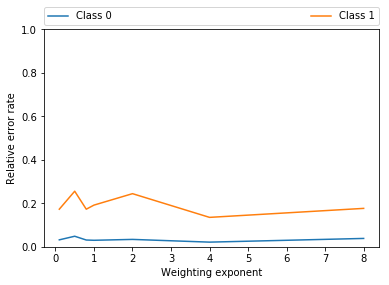

In [16]:
scores_comp = pd.DataFrame(columns=['Class 0', 'Class 1'], index= [0.1,0.5,0.8,1,2,4,8]).fillna(0)

for i in [0.1,0.5,0.8,1,2,4,8]:
    rar_data = pd.concat([X_train, y_train], axis=1)
    # RaR uses columns with string label only
    rar_data.rename(columns=lambda c: str(c), inplace=True)
    target = str(target)
    rar_compensate = csrar.rar.RaR(rar_data)
    rar_compensate.run(target, k=5, runs=100, split_iterations=10, compensate_imbalance=True, weight_mod=i)

    # Evaluate, average relative error rates
    errors = eval_rar_ranking(rar_compensate.feature_ranking, target, k=4)
    scores_comp.loc[i, 'Class 0'] = errors[0][0]
    scores_comp.loc[i, 'Class 1'] = errors[1][0]

import matplotlib.pyplot as plt
plt.plot(scores_comp['Class 0'], label='Class 0')
plt.plot(scores_comp['Class 1'], label='Class 1')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
axes = plt.gca()
axes.set_ylim([0, 1])
axes.set_ylabel('Relative error rate')
axes.set_xlabel('Weighting exponent')
plt.savefig('weight_higher_page-blocks0')
plt.show()

In [12]:
scores_comp

,Class 0,Class 1
0.1,0.026721,0.157895
0.5,0.029150,0.172932
0.8,0.024291,0.146617
1.0,0.028745,0.165414
2.0,0.027126,0.161654
4.0,0.025911,0.154135
8.0,0.026721,0.172932
16.0,0.029960,0.135338


In [ ]:
scores

In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores['Class 0'], label='Class 0')
plt.plot(scores['Class 1'], label='Class 1')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('RaR_test5_imb_nocomp')
plt.show()

In [ ]:
error_frame2 = eval_rar_ranking(rar_compensate.feature_ranking, k=4)
error_frame2

## Cost Analysis

### With selection

In [8]:
def eval_rar_ranking(ranking, target, k=3):
    from imblearn.over_sampling import SMOTE
    
    clf_selected = ExtraTreesClassifier(n_jobs=-1)
    selected_features = list(map(lambda f: f[0], ranking[:k]))
    X_train_s = X_train[selected_features]
    X_test_s = X_test[selected_features]
    
    # Rebalance
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(X_train_s, y_train)
    
    clf_selected.fit(X_res, y_res)
    y_predict = clf_selected.predict(X_test_s)
    error_rates = dict([(value, {'sum': 0, 'errors': 0}) for value in np.unique(data[target])])
    for real, predicted in zip(y_test, y_predict):
        if real != predicted:
            error_rates[real]['errors'] += 1
        error_rates[real]['sum'] += 1

    error_frame = pd.DataFrame(index=[0], columns=np.unique(data[target]))
    for value, rates in error_rates.items():
        error_frame[value] = [rates['errors'] / (rates['sum'])]
    return error_frame

### Without selection

In [ ]:
# Resampling for imbalanced learn
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)

In [ ]:
clf = ExtraTreesClassifier(n_jobs=-1)
clf.fit(X_res, y_res)

y_predict = clf.predict(X_test)
error_rates = dict([(value, {'sum': 0, 'errors': 0}) for value in np.unique(data[150])])
for real, predicted in zip(y_test, y_predict):
    if real != predicted:
        error_rates[real]['errors'] += 1
    error_rates[real]['sum'] += 1
error_frame = pd.DataFrame(index=[0], columns=np.unique(data[150]))
for value, rates in error_rates.items():
    error_frame[value] = [rates['errors'] / (rates['sum'])]
error_frame

In [ ]:
len(list(filter(lambda p: p == 1.0, y_predict)))

In [ ]:
error_rates

In [ ]:
clf.score(X_test, y_test)

## DecisionTreeClassifier for Feature Ranking

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
%pdb 1
y_predict = clf.predict(X_test)
error_rates = dict([(value, {'sum': 0, 'errors': 0}) for value in np.unique(data[150])])
for real, predicted in zip(y_test, y_predict):
    if real != predicted:
        error_rates[real]['errors'] += 1
    error_rates[real]['sum'] += 1
error_frame = pd.DataFrame(index=[0], columns=np.unique(data[150]))
for value, rates in error_rates.items():
    error_frame[value] = [rates['errors'] / (rates['sum'])]
error_frame

In [ ]:
ranking = []
for index, importance in enumerate(clf.feature_importances_):
    ranking.append((data.columns[index], importance))
ranking.sort(key=lambda r: r[1], reverse=True)
for (index, rank) in enumerate(ranking):
        print('{}. {} with a score of {}'.format(index + 1, rank[0], rank[1]))

## Benchmarking with top k features

In [ ]:
import sys

scores = pd.DataFrame(columns=['RaR', 'DecisionTree'], index=np.arange(40))
scores = scores.fillna(0)
max_k = 40

# RaR
for i in range(1,max_k):
    clf_selected = ExtraTreesClassifier(max_features=i, n_jobs=-1)
    selected_features = list(map(lambda f: int(f[0]), rar.feature_ranking[:i]))
    X_train_s = X_train[selected_features]
    X_test_s = X_test[selected_features]
    clf_selected.fit(X_train_s, y_train)
    scores.loc[i, 'RaR'] = clf_selected.score(X_test_s, y_test)
    sys.stdout.write('\rBenchmark: {}%     '.format(100 * i / (2*max_k)))
    sys.stdout.flush()
    
# DecisionTree
for i in range(1,max_k):
    clf_selected = ExtraTreesClassifier(max_features=i, n_jobs=-1)
    selected_features = [r[0] for r in ranking[:i]]
    X_train_s = X_train[selected_features]
    X_test_s = X_test[selected_features]
    clf_selected.fit(X_train_s, y_train)
    scores.loc[i, 'DecisionTree'] = clf_selected.score(X_test_s, y_test)
    sys.stdout.write('\rBenchmark: {}%     '.format(50 + 100 * i / (2*max_k)))
    sys.stdout.flush()
print('Benchmark: 100.0%')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores['DecisionTree'], label='DecisionTree')
plt.plot(scores['RaR'], label='RaR')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('test4_FS_ExtraTrees_Score')
plt.show()

## Other

In [ ]:
# In case we need to look at the tree
from sklearn import tree
import pydot
from sklearn.externals.six import StringIO
dot_data = StringIO()
tree.export_graphviz(clf, out_file='tree.dot')